# LastFM Gender Balanced Output Analysis

This notebook contains our analysis of the recommender evaluation results.

It proceeds in a few steps:

1. [Setup](#Setup), where we do the initial R configuration
2. [Read Data](#Read-Data), where we load in the experiment data for analysis
3. [Controlling for Profile Size](#Controlling-for-Profile-Size), where we model accuracy as a function of user profile size in order to control for intrinsic profile difficulty
4. [Gender](#Gender), where we analyze the results by gender.
5. [Age](#Age), where we analyze the results by age.

## Setup

Libraries:

In [11]:
library(plyr)
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)
source("plot-tools.R")

Options:

In [12]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

Copy in the `bound_ages` function from the input analysis:

In [13]:
ml_age_lbs = c(1, 18, 25, 35, 45, 50, 56)
bound_ages = function(ages, bounds=ml_age_lbs) {
    ages[ages <= 0] = NA
    selectors = rowSums(outer(ages, ml_age_lbs, ">="))
    factor(ml_age_lbs[selectors], levels=as.character(bounds))
}

## Read Data

First, we need to read the user data from the underlying Last.FM data:

In [17]:
users.meta.360k = read_csv("build/lastfm-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)
users.meta.360k

Parsed with column specification:
cols(
  id = col_integer(),
  key = col_character(),
  gender = col_character(),
  age = col_integer()
)


user,gender,age
1,F,18
2,F,NA
3,NA,NA
4,M,18
5,M,25
⋮,⋮,⋮
359343,M,25
359344,M,25
359345,M,18
359346,M,18


In [22]:
users.meta = users.meta.360k %>%
    mutate(DataSet='LFM360K.GB') %>%
    select(DataSet, user, gender, age) %>%
    mutate(DataSet = as.factor(DataSet))

In [23]:
users.meta

DataSet,user,gender,age
LFM360K.GB,1,F,18
LFM360K.GB,2,F,NA
LFM360K.GB,3,NA,NA
LFM360K.GB,4,M,18
LFM360K.GB,5,M,25
⋮,⋮,⋮,⋮
LFM360K.GB,359343,M,25
LFM360K.GB,359344,M,25
LFM360K.GB,359345,M,18
LFM360K.GB,359346,M,18


Now, we want to get user profile statistics. In order to do that, we need each user's train profile; we can load that from the training data output by the cross-folding process.

For each partition, we need to load the _train ratings_ (historical profile) for all the _test users_ in that partition. So we will load the test data (to get the users) and the train data (to get the histories), then merge them.

In [24]:
train.ratings.360k = ldply(1:5, function(part) {
    message("reading part ", part)
    test.fn = sprintf("build/lastfm-splits-sample/u.part%d.test.csv", part)
    train.fn = sprintf("build/lastfm-splits-sample/u.part%d.train.csv", part)
    test = suppressMessages(read_csv(test.fn))
    train = suppressMessages(read_csv(train.fn))
    test %>%
        select(user) %>%
        distinct() %>%
        mutate(part=as.factor(part)) %>%
        inner_join(train)
})
head(train.ratings.360k)

reading part 1
Joining, by = "user"
reading part 2
Joining, by = "user"
reading part 3
Joining, by = "user"
reading part 4
Joining, by = "user"
reading part 5
Joining, by = "user"


user,part,item,count
112429,1,2130,491
112429,1,1277,199
112429,1,7930,196
112429,1,2256,164
112429,1,12770,156
112429,1,159,117


In [25]:
train.ratings = train.ratings.360k %>%
    mutate(DataSet = 'LFM360K.GB') %>%
    mutate(DataSet = as.factor(DataSet)) %>%
    select(DataSet, user, part, item, count)

In [26]:
train.ratings

user,part,item,count,DataSet
112429,1,2130,491,LFM360K.GB
112429,1,1277,199,LFM360K.GB
112429,1,7930,196,LFM360K.GB
112429,1,2256,164,LFM360K.GB
112429,1,12770,156,LFM360K.GB
⋮,⋮,⋮,⋮,⋮
279454,5,1484,26,LFM360K.GB
279454,5,798,26,LFM360K.GB
279454,5,2255,25,LFM360K.GB
279454,5,159,25,LFM360K.GB


Quick summary just to see what this data looks like:

In [27]:
train.ratings %>%
    select(DataSet, part, count) %>%
    summary()

       DataSet        part           count         
 LFM360K.GB:1093405   1:218947   Min.   :     1.0  
                      2:218266   1st Qu.:    34.0  
                      3:219063   Median :    92.0  
                      4:218728   Mean   :   209.6  
                      5:218401   3rd Qu.:   216.0  
                                 Max.   :141661.0  

Now we want to compute per-user profile statistics:

In [28]:
user.stats = train.ratings %>%
    group_by(DataSet, user) %>%
    summarize(nartists = n(), meanPlays=mean(count), medPlays=median(count), totalPlays=sum(count))
user.stats

DataSet,user,nartists,meanPlays,medPlays,totalPlays
LFM360K.GB,1,44,352.772727,230.0,15522
LFM360K.GB,9,44,5.090909,4.0,224
LFM360K.GB,16,42,356.023810,319.5,14953
LFM360K.GB,46,57,282.964912,180.0,16129
LFM360K.GB,60,43,248.139535,198.0,10670
⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,359275,45,840.6222,769,37828
LFM360K.GB,359311,40,14.0000,12,560
LFM360K.GB,359312,49,141.4082,96,6929
LFM360K.GB,359321,42,239.0714,140,10041


Join these statistics with our user metadata table, so that we have one table of user information:

In [29]:
users = users.meta %>% inner_join(user.stats)
users

Joining, by = c("DataSet", "user")


DataSet,user,gender,age,nartists,meanPlays,medPlays,totalPlays
LFM360K.GB,1,F,18,44,352.772727,230.0,15522
LFM360K.GB,9,F,18,44,5.090909,4.0,224
LFM360K.GB,16,M,18,42,356.023810,319.5,14953
LFM360K.GB,46,M,NA,57,282.964912,180.0,16129
LFM360K.GB,60,F,18,43,248.139535,198.0,10670
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,359275,F,NA,45,840.6222,769,37828
LFM360K.GB,359311,M,35,40,14.0000,12,560
LFM360K.GB,359312,M,18,49,141.4082,96,6929
LFM360K.GB,359321,F,25,42,239.0714,140,10041


Now that we have user information, we can read the per-user recommender evaluation results.

In [30]:
user.results.360k = read_csv("build/lastfm-balanced-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    mutate(DataSet = "LFM360K.GB")
user.results.360k %>% select(nDCG, RecipRank, AvgPrec) %>% summary()

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  L10K.Rank = col_integer(),
  Rank = col_integer()
)
See spec(...) for full column specifications.


      nDCG           RecipRank            AvgPrec     
 Min.   :0.00000   Min.   :0.0000000   Min.   :0.00   
 1st Qu.:0.07805   1st Qu.:0.0000537   1st Qu.:0.00   
 Median :0.10319   Median :0.0008757   Median :0.00   
 Mean   :0.13623   Mean   :0.0965536   Mean   :0.04   
 3rd Qu.:0.16402   3rd Qu.:0.0322581   3rd Qu.:0.03   
 Max.   :0.99713   Max.   :1.0000000   Max.   :1.00   
                                       NA's   :50000  

In [31]:
user.results = user.results.360k %>%
    mutate(DataSet=as.factor(DataSet),
           Algorithm=as.factor(Algorithm)) %>%
    inner_join(users)
user.results

Joining, by = c("DataSet", "user")


DataSet,Partition,Algorithm,user,TestTime,Rank.nDCG,L100.Rank,L100.RecipRank,L100.nDCG,L100.AvgPrec,⋯,Rank,RecipRank,nDCG,AvgPrec,gender,age,nartists,meanPlays,medPlays,totalPlays
LFM360K.GB,5,UU-B,241257,2.946,0,NA,0,0,NA,⋯,NA,0,0,NA,F,18,47,272.89362,171,12826
LFM360K.GB,4,UU-C,236288,3.003,0,NA,0,0,NA,⋯,NA,0,0,NA,M,18,39,27.10256,15,1057
LFM360K.GB,3,UU-C,238351,3.015,0,NA,0,0,NA,⋯,NA,0,0,NA,M,18,47,23.51064,14,1105
LFM360K.GB,5,UU-C,241257,3.030,0,NA,0,0,NA,⋯,NA,0,0,NA,F,18,47,272.89362,171,12826
LFM360K.GB,3,UU-B,238351,3.053,0,NA,0,0,NA,⋯,NA,0,0,NA,M,18,47,23.51064,14,1105
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,1,II-B,2454,0.878,0.9786268,1,1.0000000,0.46868978,0.40211640,⋯,1,1.0000000,0.5184497,0.24517077,M,18,54,118.98148,88.5,6425
LFM360K.GB,1,II-B,44667,0.833,0.7707650,3,0.3333333,0.23238157,0.20693976,⋯,3,0.3333333,0.2888432,0.16810283,M,18,58,151.27586,131.5,8774
LFM360K.GB,1,II-B,35706,0.808,0.6387630,10,0.1000000,0.04326819,0.06315789,⋯,10,0.1000000,0.1510542,0.03651757,M,18,42,99.16667,32.5,4165
LFM360K.GB,1,II-B,11621,0.812,0.9861884,1,1.0000000,0.48606784,0.32137083,⋯,1,1.0000000,0.5055259,0.25811086,F,18,43,612.16279,427.0,26323


In [38]:
write_csv(user.results, "build/lfm-integrated-user-results.csv")

## Gender

Let's analyze accuracy by gender.

In [32]:
gender.results = user.results %>%
    select(DataSet, Algorithm, gender, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", -DataSet, -Algorithm, -gender) %>%
    group_by(DataSet, Algorithm, gender, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup() %>%
    mutate(gender=ifelse(is.na(gender), "?", as.character(gender)))
gender.results

DataSet,Algorithm,gender,Metric,value
LFM360K.GB,II-B,F,MAP,0.1065419
LFM360K.GB,II-B,F,MRR,0.2940326
LFM360K.GB,II-B,F,nDCG,0.2952459
LFM360K.GB,II-B,F,Rank.nDCG,0.8908668
LFM360K.GB,II-B,M,MAP,0.1088798
⋮,⋮,⋮,⋮,⋮
LFM360K.GB,UU-C,F,Rank.nDCG,0
LFM360K.GB,UU-C,M,MAP,NA
LFM360K.GB,UU-C,M,MRR,0
LFM360K.GB,UU-C,M,nDCG,0


In [33]:
overall.results = user.results %>%
    select(DataSet, Algorithm, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", -DataSet, -Algorithm) %>%
    group_by(DataSet, Algorithm, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup() %>%
    mutate(gender = 'Any')
combined.results = rbind(gender.results, overall.results) %>%
    mutate(gender=factor(gender, levels=c("F", "M", "?", "Any"), ordered=TRUE))
head(combined.results)

DataSet,Algorithm,gender,Metric,value
LFM360K.GB,II-B,F,MAP,0.1065419
LFM360K.GB,II-B,F,MRR,0.2940326
LFM360K.GB,II-B,F,nDCG,0.2952459
LFM360K.GB,II-B,F,Rank.nDCG,0.8908668
LFM360K.GB,II-B,M,MAP,0.1088798
LFM360K.GB,II-B,M,MRR,0.3016779


Warning message:
“Removed 6 rows containing missing values (geom_bar).”

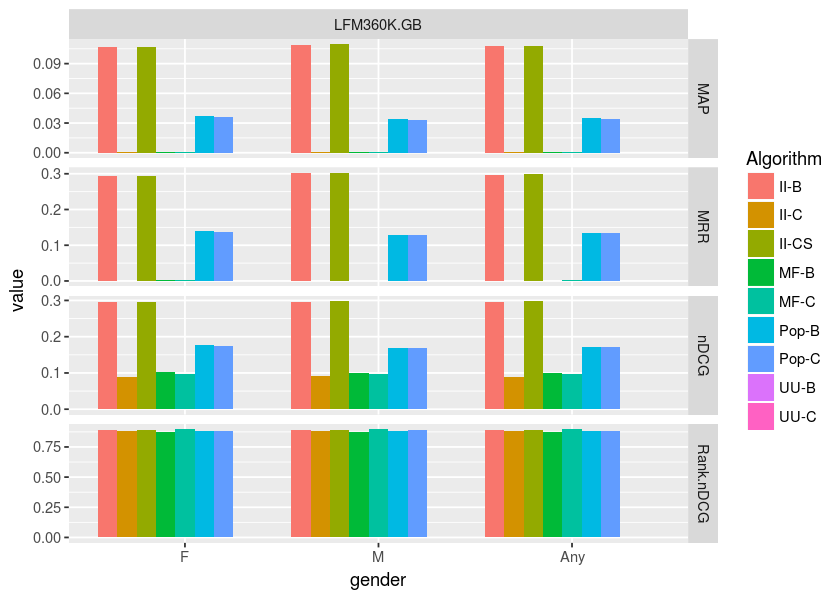

In [34]:
ggplot(combined.results) +
    aes(x=gender, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_grid(Metric ~ DataSet, scales="free")

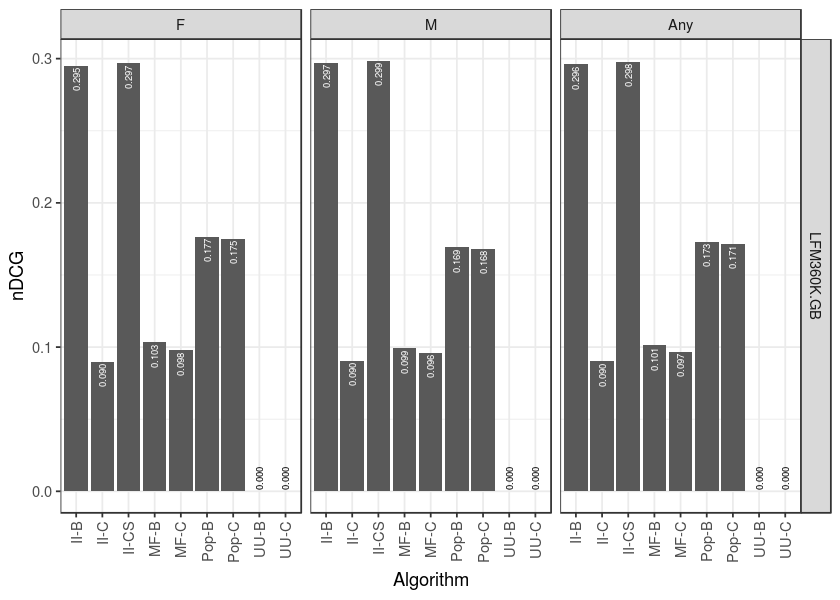

In [35]:
make.plot("lastfm-gender-ndcg", width=5, height=3, {
    ggplot(combined.results %>% filter(Metric == "nDCG")) +
        aes(x=Algorithm, y=value) +
        geom_bar(stat="identity") +
        geom_text(mapping=aes(label=sprintf("%.03f", value),
                              hjust=ifelse(value > 0.025, 1.1, -0.05),
                              color=ifelse(value > 0.025, "white", "black")),
                  size=2, vjust=0.5, angle=90) +
        scale_color_identity() +
        facet_grid(DataSet ~ gender, scales="free_y") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("nDCG")
})

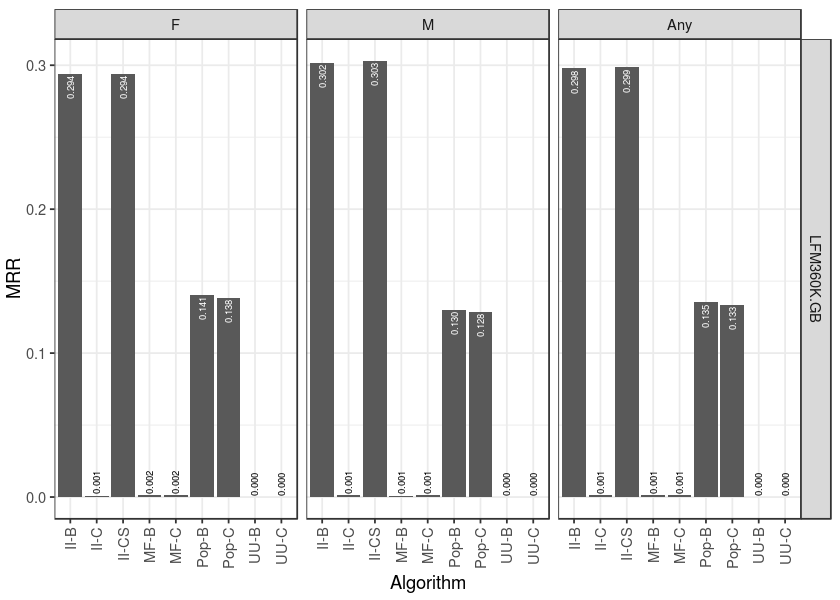

In [36]:
make.plot("lastfm-gender-mrr", width=5, height=3, {
    ggplot(combined.results %>% filter(Metric == "MRR")) +
        aes(x=Algorithm, y=value) +
        geom_bar(stat="identity") +
        geom_text(mapping=aes(label=sprintf("%.03f", value),
                              hjust=ifelse(value > 0.025, 1.1, -0.05),
                              color=ifelse(value > 0.025, "white", "black")),
                  size=2, vjust=0.5, angle=90) +
        scale_color_identity() +
        facet_grid(DataSet ~ gender, scales="free_y") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("MRR")
})

## Age

Now we wish to do the same thing by age.

In [37]:
age.results = user.results %>%
    select(DataSet, Algorithm, age, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", MAP, MRR, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm, age, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup()
age.results

DataSet,Algorithm,age,Metric,value
LFM360K.GB,II-B,1,MAP,0.1263378
LFM360K.GB,II-B,1,MRR,0.3401224
LFM360K.GB,II-B,1,nDCG,0.3209175
LFM360K.GB,II-B,1,Rank.nDCG,0.8858405
LFM360K.GB,II-B,18,MAP,0.1076804
⋮,⋮,⋮,⋮,⋮
LFM360K.GB,UU-C,56,Rank.nDCG,0
LFM360K.GB,UU-C,NA,MAP,NA
LFM360K.GB,UU-C,NA,MRR,0
LFM360K.GB,UU-C,NA,nDCG,0


In [40]:
overall.results = user.results %>%
    select(DataSet, Algorithm, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", MAP, MRR, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup() %>%
    mutate(age = 'Any')
age.combined.results = rbind(age.results, overall.results) %>%
    filter(DataSet == "LFM360K.GB")
head(age.combined.results)

DataSet,Algorithm,age,Metric,value
LFM360K.GB,II-B,1,MAP,0.1263378
LFM360K.GB,II-B,1,MRR,0.3401224
LFM360K.GB,II-B,1,nDCG,0.3209175
LFM360K.GB,II-B,1,Rank.nDCG,0.8858405
LFM360K.GB,II-B,18,MAP,0.1076804
LFM360K.GB,II-B,18,MRR,0.2979325


Warning message:
“Removed 18 rows containing missing values (geom_bar).”

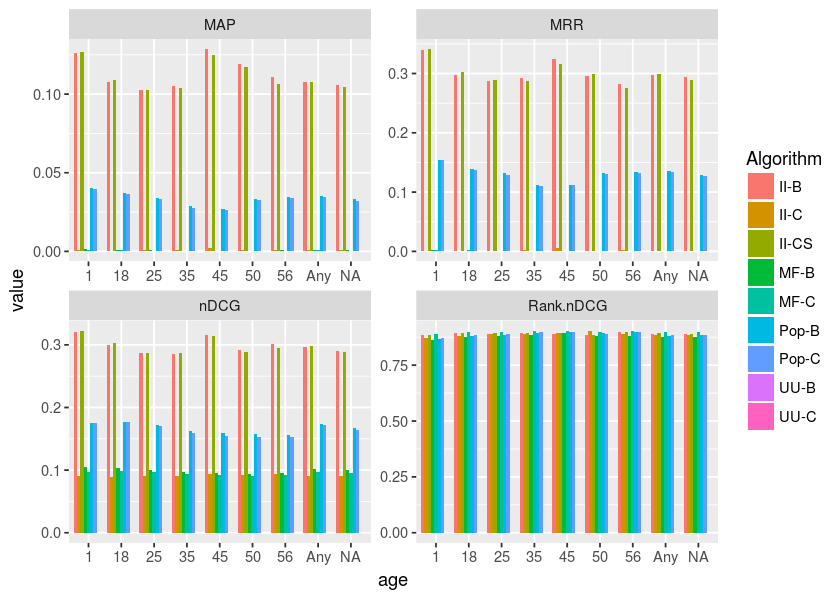

In [41]:
ggplot(age.combined.results) +
    aes(x=age, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_wrap(~ Metric, scales="free")